#### Bibliotecas

In [1]:
from datetime import datetime
from time import time
from contextlib import contextmanager
from typing import List, Union

from somperf.metrics import *
from somperf.utils.topology import rectangular_topology_dist

import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import pearsonr,kruskal
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from sklearn import preprocessing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from minisom import MiniSom

from tsai.all import *


os.environ["DEVICE"] = "cuda"

## Pré-processamento dos dados

### Cálculo do GPP

In [2]:
set_seed(1, False)
@contextmanager
def cwd(path: str) -> None:

    """
    Context manager para mudar o diretório de trabalho.
    Mantém o diretório original após a execução do bloc
    
    o de código.
    """

    oldpwd = os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

def constructor_2(path):
    df = pd.read_csv(path, parse_dates=['date'])
    # Definindo a coluna 'system:time_start' como índice
    hora_inicio = df['date'].min().floor('d')
    df.index = hora_inicio + pd.to_timedelta(df.index, unit='h')
    # Removendo a coluna 'system:time_start'
    df = df.drop(['date','.geo'], axis=1)
    df = df.drop('system:index',axis=1)
    return df

def modis_date(data_str):
    ano = int(data_str[1:5])
    dia_ano = int(data_str[5:])
    data = datetime.strptime('{}-{}'.format(ano, dia_ano), '%Y-%j')
    return data

def df_xy(x,y):
    x_df = pd.DataFrame(x[:,0]).reset_index().drop('index',axis=1)
    x_df.columns = [f'janela {i}' for i in range(len(x_df.columns))]

    y_df = pd.DataFrame(y).reset_index().drop('index',axis=1)
    y_df.columns = [f'previsao {i}' for i in range(len(y_df.columns))]

    return pd.concat([x_df,y_df],axis=1)

@contextmanager
def cwd(path: str) -> None:

    """
    Context manager para mudar o diretório de trabalho.
    Mantém o diretório original após a execução do bloco de código.
    """

    oldpwd = os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

def read_data():
    with cwd('dados/Merra/dados_otimizados'):
        dados = []
        for csv in sorted(os.listdir()):
            name = csv.split('_')[1]
            df = pd.read_csv(csv)
            datetime = df['index']
            df.index = pd.to_datetime(datetime)
            df = df['GPP']
            dados.append(pd.DataFrame(df.values,columns=[name],index=datetime))
        return dados

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ",device)

gpp_cax, gpp_peru, gpp_santarem = read_data()
gpp_todos = pd.concat([gpp_peru,gpp_santarem,gpp_cax],axis=1)

Device:  cpu


### Divisão do dataset em treino e teste

In [3]:
train, test = train_test_split(gpp_todos,test_size=0.15,shuffle=False,random_state=1) # Não embaralhado
train_date = train.index
test_date = test.index

gpp_peru_train, gpp_santarem_train, gpp_cax_train = gpp_peru.loc[train_date].copy(),gpp_santarem.loc[train_date].copy(),gpp_cax.loc[train_date].copy()
gpp_peru_test, gpp_santarem_test, gpp_cax_test = gpp_peru.loc[test_date].copy(),gpp_santarem.loc[test_date].copy(),gpp_cax.loc[test_date].copy()

In [4]:
gpp_peru_test.to_csv('dados/TrainTestVal_dataset/dados_datasetTeste/gpp_peru_test.csv')
gpp_santarem_test.to_csv('dados/TrainTestVal_dataset/dados_datasetTeste/gpp_santarem_test.csv')
gpp_cax_test.to_csv('dados/TrainTestVal_dataset/dados_datasetTeste/gpp_cax_test.csv')

### Criação da janela temporal

In [5]:
peru_x_test,peru_y_test = SlidingWindow(8,horizon=8,seq_first=True,stride = None)(gpp_peru_test)                                                                                     
santarem_x_test,santarem_y_test = SlidingWindow(8,horizon=8,seq_first=True,stride = None)(gpp_santarem_test)
cax_x_test,cax_y_test = SlidingWindow(8,horizon=8,seq_first=True,stride = None)(gpp_cax_test)


# Transformação em Dataframe para melhor manipulação dos dados
peru_xtest = pd.DataFrame(peru_x_test.reshape(-1, 8))
peru_ytest = pd.DataFrame(peru_y_test)
peru_ytest['localidade'] = 'peru'

santarem_xtest = pd.DataFrame(santarem_x_test.reshape(-1, 8))
santarem_ytest = pd.DataFrame(santarem_y_test)
santarem_ytest['localidade'] = 'santarem'

cax_xtest = pd.DataFrame(cax_x_test.reshape(-1, 8))
cax_ytest = pd.DataFrame(cax_y_test)
cax_ytest['localidade'] = 'caxiuana'

x_test_df = pd.concat([peru_xtest,
                       santarem_xtest,
                       cax_xtest,
                       ],
                      ignore_index=True)


y_test_df = pd.concat([pd.DataFrame(peru_ytest),
                       pd.DataFrame(santarem_ytest),
                       pd.DataFrame(cax_ytest),
                       ],
                      ignore_index=True)


X_test = x_test_df.values.reshape(-1, 1, 8) # (n° observações, características, janela de observação)
y_test = y_test_df.drop('localidade',axis=1).values
y_labels = y_test_df['localidade']
y_labels.to_csv('dados/TrainTestVal_dataset/y_labels.csv')

In [6]:
peru_x_train,peru_y_train = SlidingWindow(8,horizon=8,seq_first=True,stride = None)(gpp_peru_train) 
santarem_x_train,santarem_y_train = SlidingWindow(8,horizon=8,seq_first=True,stride = None)(gpp_santarem_train)
cax_x_train,cax_y_train = SlidingWindow(8,horizon=8,seq_first=True,stride = None)(gpp_cax_train)

peru_df = df_xy(peru_x_train,peru_y_train)
santarem_df = df_xy(santarem_x_train,santarem_y_train)
cax_df = df_xy(cax_x_train,cax_y_train)

peru_df['localidade'] = 'peru'
santarem_df['localidade'] = 'santarem'
cax_df['localidade'] = 'caxiuana'


gpp_geral = pd.concat([peru_df,santarem_df,cax_df]).reset_index().drop('index',axis=1)

### Geração de Características das séries

In [8]:
previsao = [f'previsao {i}' for i in range(0,8)]

X = gpp_geral.drop(columns=['localidade']).drop(columns=previsao)  # Aqui ficam 8 colunas representado instantes da janela temporal
y = gpp_geral[previsao] # Aqui fica os próximos 8 valores da sequência
z = gpp_geral[['localidade']]

ts_features_df = get_ts_features(X=X.values.reshape(X.shape[0],1,X.shape[1]),y=y.values,features='all')
ts_features_df = ts_features_df.dropna(axis=1) # Removendo colunas com valores nulos

Feature Extraction: 100%|███████████████████████| 60/60 [00:50<00:00,  1.19it/s]


### Clusterização com SOM

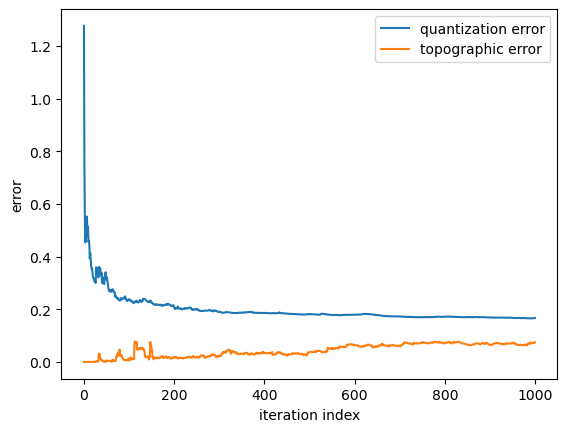

In [9]:
norm = preprocessing.Normalizer()

datos = norm.fit_transform(ts_features_df.values)

map_size = round(np.sqrt(round(5 * np.sqrt(len(ts_features_df))))) # arredondando pra um inteiro com raiz exata = 256 = 16x16

som_shape = [map_size, map_size]
som = MiniSom(som_shape[0], som_shape[1], datos.shape[-1],neighborhood_function='gaussian',activation_distance='euclidean',random_seed=1)
som.pca_weights_init(datos)

max_iter = 1000
q_error = []
t_error = []

for i in range(max_iter):
    rand_i = np.random.randint(len(datos))
    som.update(datos[rand_i], som.winner(datos[rand_i]), i, max_iter)
    q_error.append(som.quantization_error(datos))
    t_error.append(som.topographic_error(datos))

plt.plot(np.arange(max_iter), q_error, label='quantization error')
plt.plot(np.arange(max_iter), t_error, label='topographic error')
plt.ylabel('error')
plt.xlabel('iteration index')
plt.legend()
plt.show()

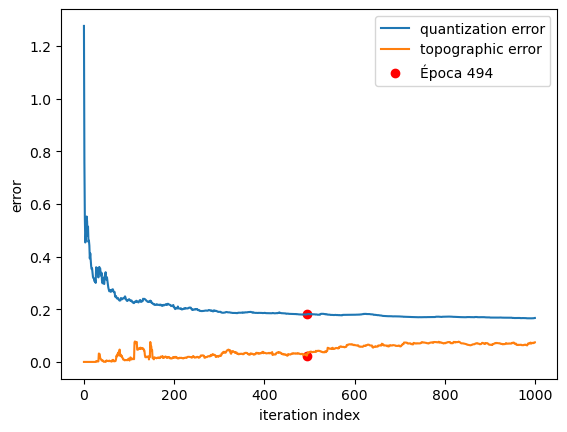

In [10]:
indice_menores_erros = np.argmin([(x + y)/2 for x, y in zip(q_error, t_error)])

plt.plot(np.arange(max_iter), q_error, label='quantization error')
plt.plot(np.arange(max_iter), t_error, label='topographic error')
plt.scatter(indice_menores_erros, q_error[indice_menores_erros], color='red', label=f'Época {indice_menores_erros}')
plt.scatter(indice_menores_erros, t_error[indice_menores_erros], color='red')
plt.ylabel('error')
plt.xlabel('iteration index')
plt.legend()
plt.show()

In [11]:
som.train_batch(datos, indice_menores_erros, verbose=False)

In [12]:
# get weights as a (256, 314) array
weights = som.get_weights().reshape(som_shape[0]*som_shape[1], -1)
print("Dimensões da SOM: ",som_shape)

tp_product = topographic_product(rectangular_topology_dist(som_shape), weights)
print("Produto Topográfico: ",tp_product)

# Cálculo do erro de Kruskal-Shepard
ks_error = kruskal_shepard_error(rectangular_topology_dist(som_shape), datos, som=weights)
print("Erro de Kruskal-Shepard:", ks_error)

#Cálculo do erro de quantização
quantization_error = som.quantization_error(datos)
print("Erro de quantização:", quantization_error)

#Cálculo do erro topográfico
topographic_error = som.topographic_error(datos)
print("Erro topográfico:", topographic_error)

Dimensões da SOM:  [16, 16]
Produto Topográfico:  0.0351564892714697
Erro de Kruskal-Shepard: 0.0331278678356344
Erro de quantização: 0.16015869806063007
Erro topográfico: 0.08387096774193549


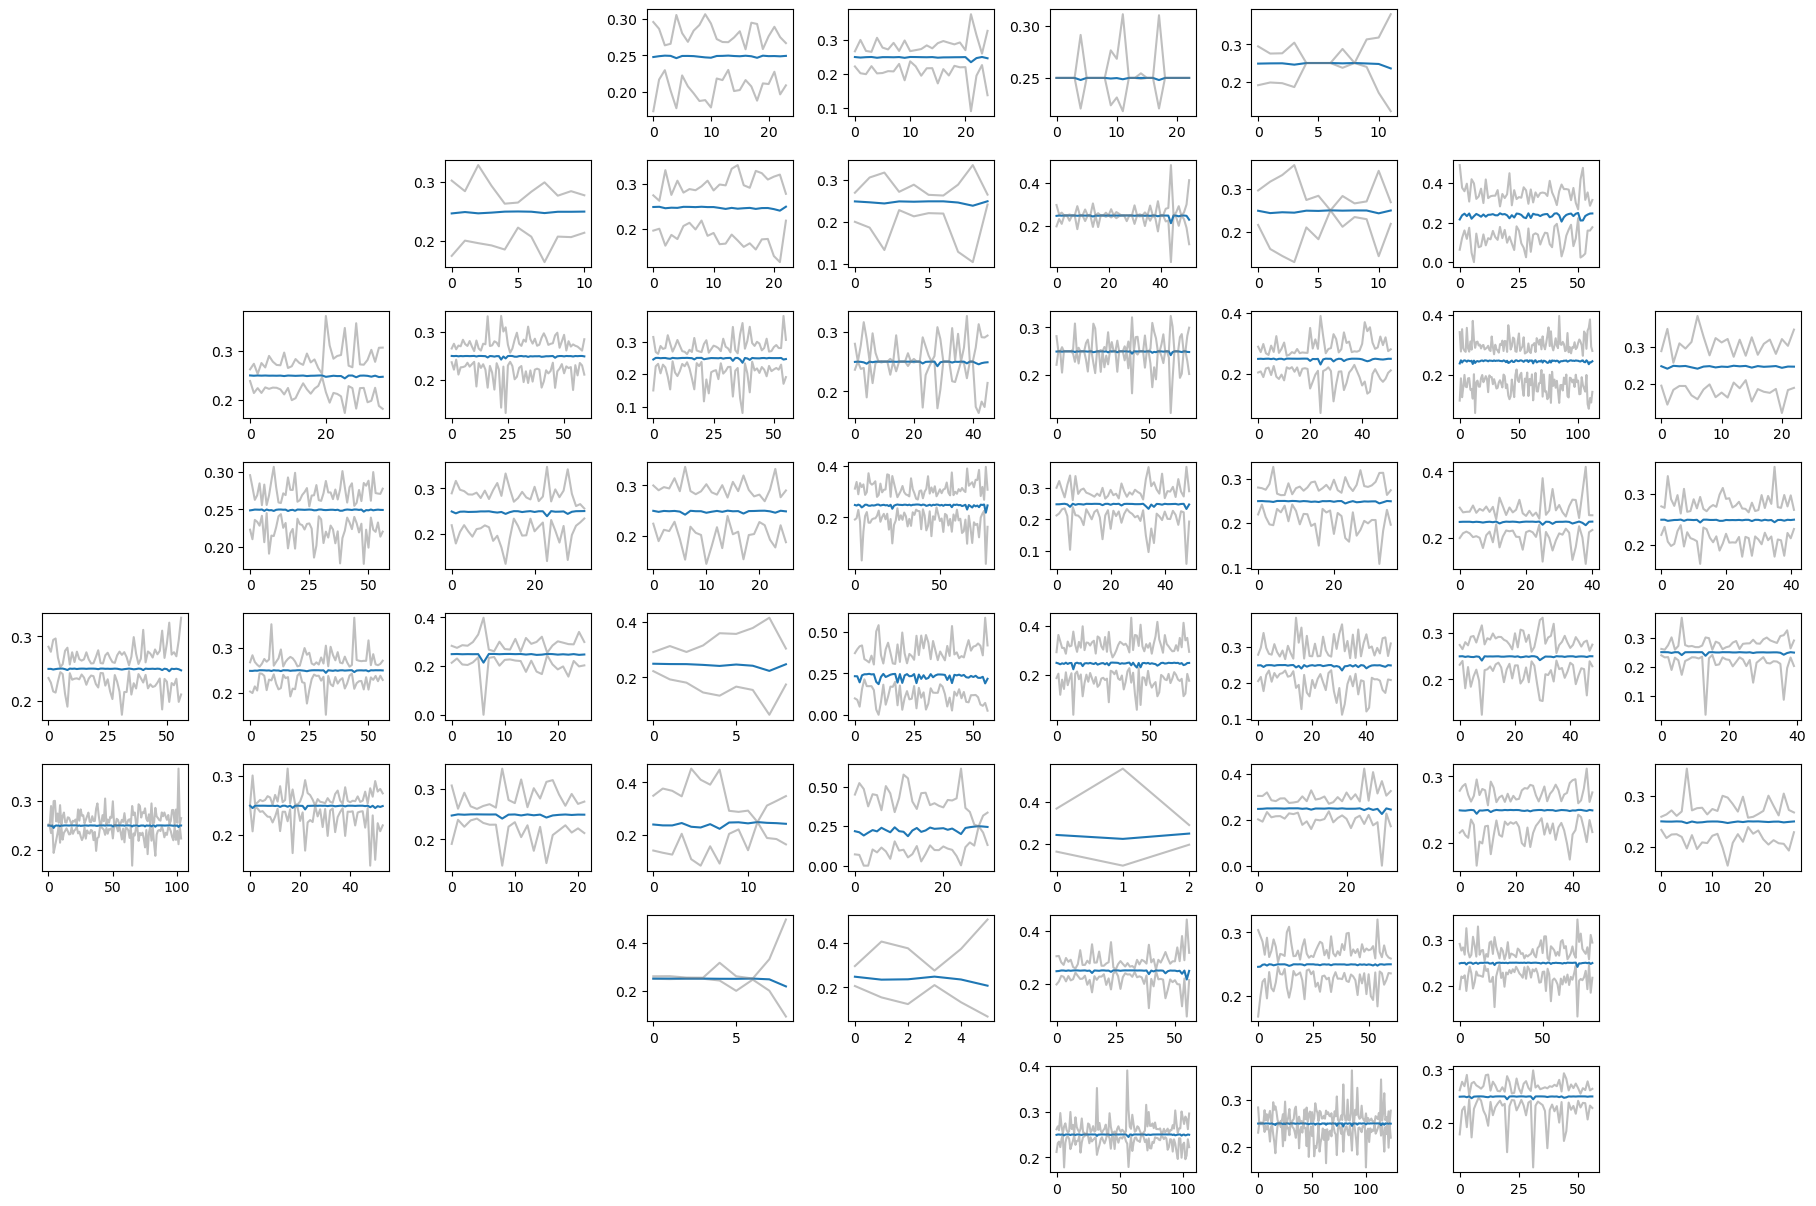

In [13]:
winner_coordinates = [som.winner(x) for x in datos]

if "cluster" in gpp_geral.columns:
    gpp_geral.drop(columns='cluster')

cluster_index = np.ravel_multi_index(np.array(winner_coordinates).T, som_shape)
gpp_geral['cluster'] = np.array(cluster_index)

win_map_gpp = {}
localidade = gpp_geral['localidade'].copy().values
norm_gpp = norm.fit_transform(gpp_geral.drop(columns=['localidade','cluster']).values)
norm_gpp_df = pd.DataFrame(norm_gpp)
#norm_gpp_df['localidade'] = localidade

# Agrupar as séries de gpp_geral associadas a cada neurônio vencedor de acordo com os clusters
for index, series in zip(winner_coordinates, norm_gpp_df.iterrows()):
    if index not in win_map_gpp:
        win_map_gpp[index] = [series[1].values]
    else:
        win_map_gpp[index].append(series[1].values)

plt.figure(figsize=(32, 24))
the_grid = GridSpec(16, 16)
for position, series_list in win_map_gpp.items():
    plt.subplot(the_grid[15 - position[1], position[0]]) 
    plt.plot(range(len(win_map_gpp[position])),np.min(win_map_gpp[position], axis=1), color='gray', alpha=.5)
    plt.plot(range(len(win_map_gpp[position])),np.mean(win_map_gpp[position], axis=1))
    plt.plot(range(len(win_map_gpp[position])),np.max(win_map_gpp[position], axis=1), color='gray', alpha=.5)
plt.tight_layout()
plt.savefig('./dados/time_series.png')
plt.show()

In [14]:
## Plot por localidade

# # Plotar as séries temporais para cada neurônio na SOM
# legend_info = {}

# # Plotar as séries temporais para cada neurônio na SOM
# plt.figure(figsize=(30, 30))
# the_grid = GridSpec(16, 16)
# for position, series_list in win_map_gpp.items():
#     plt.subplot(the_grid[15-position[1], position[0]])
#     for series in series_list:
#         localidade = series['localidade']
#         if localidade not in legend_info:
#             legend_info[localidade] = plt.plot([], [], label=localidade)[0]
#         plt.plot(range(len(series.drop(['localidade']).values)),series.drop(['localidade']), color=legend_info[localidade].get_color())

# plt.legend()
# plt.savefig('./time_series.png')
# plt.show()

In [15]:
# Contar o número de ocorrências de cada cluster por localidade
cluster_counts = gpp_geral.groupby(['localidade', 'cluster']).size()

# Filtrar os clusters para apenas os que possuem mais de 6 ocorrências para remover outliers
valid_clusters = cluster_counts[cluster_counts > 6].index

# Manter apenas as linhas cujo cluster e localidade estão nos clusters e localidades válidos
gpp_geral = gpp_geral[gpp_geral.set_index(['localidade', 'cluster']).index.isin(valid_clusters)].copy()

### Divisão Final do Dataset

In [16]:
previsao = [f'previsao {i}' for i in range(0,8)]
X = gpp_geral.drop(columns=['localidade', 'cluster']).drop(columns=previsao) 
y = gpp_geral[previsao]
z = gpp_geral[['localidade','cluster']]

# Dividir os dados em treino e validação estratificados por 'localidade' e 'cluster'
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.184, stratify=z,random_state=1)

train_data = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
X_train = train_data.drop(columns=previsao)
y_train = train_data[previsao]

val_data = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)
X_val = val_data.drop(columns=previsao)
y_val = val_data[previsao]

X_train_np = np.array(X_train)
X_val_np = np.array(X_val)
X_test_np = np.array(X_test)
y_train_np = np.array(y_train)
y_val_np = np.array(y_val)
y_test_np = np.array(y_test)

directory = './dados/TrainTestVal_dataset'
if not os.path.exists(directory):
    os.makedirs(directory)

np.save(os.path.join(directory, 'X_train.npy'), X_train_np)
np.save(os.path.join(directory, 'X_val.npy'), X_val_np)
np.save(os.path.join(directory, 'X_test.npy'), X_test_np)
np.save(os.path.join(directory, 'y_train.npy'), y_train_np)
np.save(os.path.join(directory, 'y_val.npy'), y_val_np)
np.save(os.path.join(directory, 'y_test.npy'), y_test_np)